# Single AI crypto concept

In [1]:
from xdata_config import *

WINDOW:240 - BUY_PCT:2.7 MAX_FORCAST_SIZE:240 - BUY_MODE:IS_GOOD 


## 1 - Imports and fonctions

In [2]:
from functions_module import *

2023-05-01 01:43:02.916085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-01 01:43:02.916120: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-01 01:43:02.963712: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-01 01:43:03.789937: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-01 01:43:03.790050: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

Memory usage: 3900.05 MB


In [3]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import MaxNorm
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense 
from keras.models import load_model
from keras.layers import BatchNormalization, Dense

In [4]:
def buy_optimal_5m(df,BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,window=MAX_FORCAST_SIZE):
    #df = df.fillna(0)
    mino = BUY_PCT / 100.0
    maxo = SELL_PCT / 100.0
    window=max(7,int(window/5))
    max_forecast_size=window#MAX_FORCAST_SIZE
    try:
        after_dip_val=AFTER_MARK
    except Exception:
        after_dip_val=3
    print(f"after mark = : {after_dip_val}")
    try:
        print(f"optimalbuy buy maximum forcast size={max_forecast_size} at {BUY_PCT}% of the current price ")
    except Exception:
        max_forecast_size = 3
        print("optimalbuy buy default window=3")

    rolling_max_close_diff = ((df['close-1_5min'].rolling(window=window).max().shift(-window+1) / df['close']) - 1).fillna(0)
    df['buy']=(rolling_max_close_diff >= mino).astype(int)

    # Compute rolling minimum values
    window_list=[window]#[3, 5, 7, 10, 15, 20]

    for window_size in window_list:
        col_name = f'ismin{window_size}'
        rolling_min = (df['close'].shift(after_dip_val) <= df.shift(-window_size-1)['close-1_5min'].rolling(2*window_size).min())
        df = df.assign(**{col_name: rolling_min.astype(int)})

    df['ismin'] = df[[f'ismin{window_size}' for window_size in window_list ]].any(axis=1).astype(int)        

    # # Compute buy and sell signals
    rolling_low_close_diff =  ((df['low-1_5min'].rolling(window=int(window/2)).min().shift(-int(window/2)+1)/ df['close'] ) -1).fillna(0)
    df['sell'] = (rolling_low_close_diff <= -maxo).astype(int)


    # Compute final buy signal
    df['buy'] = ((df['buy'] == 1) & (df['sell'] == 0) & (df['ismin'] == 1)).astype(int)
    # Remove unnecessary columns
    df = df.drop(columns=['sell', 'ismin'] + [f'ismin{window_size}' for window_size in window_list], errors='ignore')
    return df



def full_expand_costum(df1m,df5m,df15m,df1h,df1d,w1m=10,w5m=30,w15m=30,w1h=3,w1d=7):
    d1min=df1m.copy()
    d1min=expand_previous(d1min,window=w1m).drop(columns=["volume"])
    d1min=rapid1d_expand(d1min,df1d,w1d)
    d1min=rapid1h_expand(d1min,df1h,w1h)
    d1min=rapid15m_expand(d1min,df15m,w15m)
    d1min=rapid5m_expand(d1min,df5m,w5m)
    return d1min

def maxi_expand(pair="GMT/USDT", i=0, j=10000, window=2, metadata=MetaData,
                 high_weight=1, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT,
                 buy_function=buy_alwase,w1m=6,w5m=30,w15m=30,w1h=3,w1d=7,btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=30,btc_w1d=30):
    start_index=i
    end_index=j
    window_size=window
    buy_fn=buy_function
    """
    This function takes in several parameters to calculate technical indicators and returns a merged dataframe.
    
    :param pair: str, default "GMT/USDT"
        The trading pair to analyze.
        
    :param start_index: int, default 0
        The start index for selecting data.
        
    :param end_index: int, default 10000
        The end index for selecting data.
    
    :param window_size: int, default 2
        The window size to use for analyzing the data.
    
    :param metadata: MetaData
        The metadata to use for analyzing the data.
    
    :param high_weight: int, default 1
        The weight to use for calculating the high.
    
    :param BUY_PCT: float, default BUY_PCT
        The buy pct to use for analyzing the data.
    
    :param SELL_PCT: float, default SELL_PCT
        The sell pct to use for analyzing the data.
    
    :param buy_fn: function, default buy_min_up
        The buy function to use for analyzing the data.
    
    :return: pd.DataFrame
        A merged dataframe containing the calculated technical indicators.
    """
    print(f"maxi custum expend : {pair} with those parameters: w1m={w1m},w5m={w5m},w15m={w15m},w1h={w1h},w1d={w1d} btc_w1m={btc_w1m},btc_w5m={btc_w5m},btc_w15m={btc_w15m},btc_w1h={btc_w1h},btc_w1d={btc_w1d}")
    # Select data
    pair_df = df_list1m[pair].iloc[start_index:end_index]
    btc_df = df_list1m["BTC/USDT"].loc[(pair_df.index[0] - pd.DateOffset(days=window_size+1)).round(freq='1 min'):pair_df.index[-1]+pd.Timedelta(f"{window_size} day")]
    # Calculate technical indicators
    pair_full = full_expand_costum(pair_df, df_list5m[pair], df_list15m[pair], df_list1h[pair], df_list1d[pair],w1m=w1m,w5m=w5m,w15m=w15m,w1h=w1h,w1d=w1d)
    btc_full = full_expand_costum(btc_df, df_list5m["BTC/USDT"], df_list15m["BTC/USDT"], df_list1h["BTC/USDT"], df_list1d["BTC/USDT"], w1m=btc_w1m,w5m=btc_w5m,w15m=btc_w15m,w1h=btc_w1h,w1d=btc_w1d)   
    btc_full = btc_full.add_prefix("BTC_")
    merged = pd.merge(pair_full, btc_full, left_index=True, right_index=True)
    day_expand(merged)
    Meta_expand(merged, metadata, pair)
    #print(merged.columns)
    merged = buy_fn(merged, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=MAX_FORCAST_SIZE)
    merged["high"] = (merged["open"] + high_weight * merged["high"] + merged["low"] + merged["close"]) / (3 + high_weight)
    merged["BTC_high"] = (merged["BTC_open"] + high_weight * merged["BTC_high"] + merged["BTC_low"] + merged["BTC_close"]) / (3 + high_weight)
    merged.rename(columns={"high":"price"},inplace=True)
    merged.rename(columns={"BTC_high":"BTC_price"},inplace=True)
    merged = merged.drop(columns=["BTC_open","BTC_low","BTC_close","open","low","close"])
    open_high_low_close_cols = merged.columns.str.contains("open|high|low|close")
    # merged.loc[:, open_high_low_close_cols & merged.columns.str.contains("BTC")] = (
    #     (merged["BTC_price"] - merged.loc[:, open_high_low_close_cols & merged.columns.str.contains("BTC")]) / merged["BTC_price"]
    # )
    # merged.loc[:, open_high_low_close_cols & ~merged.columns.str.contains("BTC")] = (
    #     (merged["price"] - merged.loc[:, open_high_low_close_cols & ~merged.columns.str.contains("BTC")]) / merged["price"]
    # )
    for key in merged.keys():
        if key.find("BTC")!=-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=(merged["BTC_price"]-merged[key])/merged["BTC_price"]
        if key.find("BTC")==-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=(merged["price"]-merged[key])/merged["price"]

    merged=merged.dropna()
    print(f'######################  max expend {pair} - shape {merged.shape}  buy mean : {hp(merged.buy.mean())} ############################')
    return merged


In [5]:
def buy_optimal(df,BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,window=3):
    #df = df.fillna(0)
    mino = BUY_PCT / 100.0
    maxo = SELL_PCT / 100.0
    window=15
    max_forecast_size=15#MAX_FORCAST_SIZE
    try:
        after_dip_val=1
    except Exception:
        after_dip_val=1
    print(f"after mark = : {after_dip_val}")
    try:
        print(f"optimalbuy buy maximum forcast size={max_forecast_size} at {BUY_PCT}% of the current price ")
    except:
        max_forecast_size = 3
        print("optimalbuy buy default window=3")

    rolling_max_close_diff = ((df['close'].rolling(window=window).max().shift(-window+1) / df['close']) - 1).fillna(0)
    df['buy']=(rolling_max_close_diff >= mino).astype(int)

    # Compute rolling minimum values

    window_list=[5,window]#[3, 5, 7, 10, 15, 20]

    for window_size in window_list:
        col_name = f'ismin{window_size}'
        rolling_min = (df['close'].shift(after_dip_val) <= df.shift(-window_size-1)['close'].rolling(2*window_size).min())
        df = df.assign(**{col_name: rolling_min.astype(int)})

    df['ismin'] = df[[f'ismin{window_size}' for window_size in window_list ]].any(axis=1).astype(int)        

    # # Compute buy and sell signals
    rolling_low_close_diff =  ((df['low'].rolling(window=int(window/2)).min().shift(-int(window/2)+1)/ df['close'] ) -1).fillna(0)
    df['sell'] = (rolling_low_close_diff <= -maxo).astype(int)


    # Compute final buy signal
    df['buy'] = ((df['buy'] == 1) & (df['sell'] == 0) & (df['ismin'] == 1)).astype(int)
    # Remove unnecessary columns
    df = df.drop(columns=['sell', 'ismin'] + [f'ismin{window_size}' for window_size in window_list], errors='ignore')
    return df



In [6]:
def is_local_min(df, BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a local minimum.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    window (int): The window size for computing local minimum.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating local minimum.
    """
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=window, center=True, min_periods=1).min()

    # Check if close price is a local minimum
    local_min = (df['close'] == rolling_min_close).astype(int)

    # Add the local minimum column to the DataFrame
    df['buy'] = local_min

    return df


def is_near_min_v1(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5, num_values=3):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a local minimum
    or near the local minimum.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    window (int): The window size for computing local minimum.
    num_values (int): The number of values near the local minimum to include.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating local minimum and its neighbors.
    """
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=window, center=True, min_periods=1).min()

    # Check if close price is a local minimum or near the local minimum
    close_diff = np.abs(df['close'] - rolling_min_close)
    threshold = close_diff.nsmallest(num_values+1).iloc[-1]
    local_min = (close_diff <= threshold).astype(int)

    # Add the local minimum column to the DataFrame
    df['buy'] = local_min

    return df

import numpy as np

def is_near_min(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5, num_values=3):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a local minimum
    or within the specified range before or after the local minimum.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    window (int): The window size for computing local minimum.
    num_values (int): The number of values before and after the local minimum to include.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating local minimum and its neighbors.
    """
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=window, center=True, min_periods=1).min()

    # Check if close price is a local minimum
    local_min = (df['close'] == rolling_min_close).astype(int)

    # Add the local minimum column to the DataFrame
    df['buy'] = local_min

    # Include values before and after the local minimum
    for i in range(1, num_values+1):
        df['buy'] = df['buy'] | df['buy'].shift(-i) | df['buy'].shift(i)

    # Fill any NaN values introduced by shifting with 0
    df['buy'].fillna(0, inplace=True)

    return df


def is_max_win(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a winning trade.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    BUY_PCT (float): Minimum percentage change required for a trade to be profitable.
    window (int): The window size for computing maximum price change.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating winning trades.
    """
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=7, center=True, min_periods=1).min()

    # Check if close price is a local minimum
    local_min = (df['close'] == rolling_min_close)

    # Compute maximum price change over next `window` rows
    # max_price = df['close'].rolling(window=window, min_periods=1).max()
    # max_price_shifted = max_price.shift(-window)
    # max_price_change = ((max_price_shifted - max_price)/max_price).fillna(0)
    max_price = df['close'].shift(periods=-window+1).rolling(window=window, min_periods=1).max()#.pct_change(window=window-1)

    # Check if the maximum price change is greater than the BUY_PCT threshold
    win = (max_price >= (BUY_PCT/100+1)*df['close'])

    # Combine local minimum and winning trade conditions
    df['buy'] = (local_min & win).astype(int)

    return df

def is_close_win(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a winning trade.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    BUY_PCT (float): Minimum percentage change required for a trade to be profitable.
    window (int): The window size for computing maximum price change.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating winning trades.
    """

    max_price = df['close'].shift(periods=-window+1).rolling(window=window, min_periods=1).max()#.pct_change(window=window-1)

    # Check if the maximum price change is greater than the BUY_PCT threshold
    win = (max_price >= (BUY_PCT/100+1)*df['close'])

    # Combine local minimum and winning trade conditions
    df['buy'] = (win).astype(int)

    return df

def is_high_win(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is a winning trade.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    BUY_PCT (float): Minimum percentage change required for a trade to be profitable.
    window (int): The window size for computing maximum price change.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating winning trades.
    """
    max_price = df['high'].shift(periods=-window+1).rolling(window=window, min_periods=1).max()#.pct_change(window=window-1)

    # Check if the maximum price change is greater than the BUY_PCT threshold
    win = (max_price >= (BUY_PCT/100+1)*df['close'])

    # Combine local minimum and winning trade conditions
    df['buy'] = (win).astype(int)

    return df


def is_local_min_plus_5(df, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is 5 minutes after a local minimum.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    window (int): The window size for computing local minimum.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating 5 minutes after a local minimum.
    """
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=window, center=True, min_periods=1).min()

    # Check if close price is a local minimum
    local_min = (df['close'] == rolling_min_close).astype(int)

    # Shift local minimum by 5 rows
    local_min_plus_5 = local_min.shift(AFTER_MARK).fillna(0).astype(int)

    # Add the local minimum column to the DataFrame
    df['buy'] = local_min_plus_5

    return df


In [7]:
# df=maxi_expand(pair=pair,i=0,j=len(df_list1m[pair]),window=2,metadata=MetaData,BUY_PCT=1.7,SELL_PCT=0.3,buy_function=is_local_min)


## Special list if needed

In [8]:
# Binance_USDT_HALAL.index("ROSE/USDT")

## Checking the import

In [9]:
# # chking import
# MetaData

In [10]:
if BUY_MODE=="BUY_ONLY":
    buy_function=buy_up_only
elif BUY_MODE=="BUY_UP":
    buy_function=buy_up
elif  BUY_MODE=="BUY_DIP":
    buy_function=buy_min_up
elif  BUY_MODE=="AFTER_DEPTH":
    buy_function=buy_after_depth
elif  BUY_MODE=="BUY_UP_CLOSE":
    buy_function=buy_up_close
elif  BUY_MODE=="AFTER_DEPTH_CLOSE":
    buy_function=buy_after_depth_close
elif  BUY_MODE=="BUY_TEST":
    buy_function=buy_test
elif BUY_MODE=="BUY_MIN_CLOSE":
    buy_function=buy_min_close
elif  BUY_MODE=="SELL_TEST":
    buy_function=sell_test
elif  BUY_MODE=="BUY_FIX":
    buy_function=buy_fix
elif  BUY_MODE=="BUY_OPTIMAL":
    buy_function=buy_optimal
elif  BUY_MODE=="IS_MIN":
    buy_function=is_local_min
elif  BUY_MODE=="IS_5MIN":
    buy_function=is_local_min_plus_5
elif  BUY_MODE=="IS_HIGH":
    buy_function=is_high_win
elif  BUY_MODE=="IS_CLOSE":
    buy_function=is_close_win
elif BUY_MODE=="IS_GOOD":
    buy_function=is_good_to_buy
try:
    os.mkdir(DATA_DIR, mode = 0o777)
except Exception as e:
    print(e)
print(f"Results dir: {DATA_DIR}")



[Errno 17] File exists: '/UltimeTradingBot/Data/IS_GOOD'
Results dir: /UltimeTradingBot/Data/IS_GOOD


In [11]:
import pandas as pd

def sma(df, column='close', window=10):
    return df[column].rolling(window=window, min_periods=1).mean()

    
def is_local_min_plus_5_with_sma(df,BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT , window=5):
    """
    Add a binary column to the OHLCV DataFrame to indicate if the close price in the row is 5 minutes after a local minimum
    and confirms a change in trend using Simple Moving Averages.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the OHLCV data.
    short_sma_period (int): The window size for the short-term Simple Moving Average.
    long_sma_period (int): The window size for the long-term Simple Moving Average.
    window (int): The window size for computing local minimum.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional column indicating 5 minutes after a local minimum
                      and a change in trend.
    """
    short_sma_period=10
    long_sma_period=30
    # Compute rolling minimum close
    rolling_min_close = df['close'].rolling(window=window, center=True, min_periods=1).min()

    # Check if close price is a local minimum
    local_min = (df['close'] == rolling_min_close).astype(int)

    # Shift local minimum by 5 rows
    local_min_plus_5 = local_min.shift(5).fillna(0).astype(int)

    # Calculate short-term and long-term Simple Moving Averages
    df['short_sma'] = sma(df, window=short_sma_period)
    df['long_sma'] = sma(df, window=long_sma_period)

    # Identify trend change by comparing short-term and long-term SMAs
    trend_change = (df['short_sma'] > df['long_sma']).astype(int)

    # Combine local minimum and trend change conditions
    df['buy'] = (local_min_plus_5 & trend_change)

    # Clean up DataFrame by removing unnecessary columns
    df.drop(columns=['short_sma', 'long_sma'], inplace=True)

    return df



import pandas as pd
import numpy as np

def rsi(df, column='close', window=14):
    delta = df[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def macd(df, column='close', short_period=12, long_period=26, signal_period=9):
    exp1 = df[column].ewm(span=short_period, adjust=False).mean()
    exp2 = df[column].ewm(span=long_period, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line

def sma(df, column='close', window=10):
    return df[column].rolling(window=window, min_periods=1).mean()

def buy_signal_dl(df,BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT , window=5):
    rsi_period=14
    macd_short_period=12
    macd_long_period=26
    macd_signal_period=9
    short_sma_period=10
    long_sma_period=30
    target_pct=BUY_PCT
    # Calculate RSI
    df['rsi'] = rsi(df, window=rsi_period)

    # Calculate MACD and MACD Signal
    df['macd'], df['macd_signal'] = macd(df, short_period=macd_short_period, long_period=macd_long_period, signal_period=macd_signal_period)

    # Calculate short-term and long-term Simple Moving Averages
    df['short_sma'] = sma(df, window=short_sma_period)
    df['long_sma'] = sma(df, window=long_sma_period)

    # Identify trend change by comparing short-term and long-term SMAs
    trend_change = (df['short_sma'] > df['long_sma']).astype(int)

    # RSI Oversold Condition
    oversold = (df['rsi'] < 30).astype(int)

    # MACD Crossover
    macd_crossover = ((df['macd'] > df['macd_signal']) & (df['macd'].shift(1) <= df['macd_signal'].shift(1))).astype(int)

    # Combine conditions
    combined_signal = (trend_change & oversold & macd_crossover)

    # Calculate future price after window periods
    future_price = df['close'].shift(-window)

    # Calculate the percentage change between the current and future price
    pct_change = ((future_price - df['close']) / df['close']) * 100

    # Check if the percentage change is greater than the target percentage
    target_reached = (pct_change >= target_pct).astype(int)

    # Combine combined_signal and target_reached conditions
    df['buy'] = (combined_signal & target_reached)

    # Clean up DataFrame by removing unnecessary columns
    df.drop(columns=['rsi', 'macd', 'macd_signal', 'short_sma', 'long_sma'], inplace=True)

    return df



def buy_signal_dl_v2(df,BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT , window=5 ):
    
    rsi_period=14
    macd_short_period=12
    macd_long_period=26
    macd_signal_period=9
    short_sma_period=10
    long_sma_period=30
    target_pct=BUY_PCT
    min_pct_change=SELL_PCT
    
    # Calculate RSI
    df['rsi'] = rsi(df, window=rsi_period)

    # Calculate MACD and MACD Signal
    df['macd'], df['macd_signal'] = macd(df, short_period=macd_short_period, long_period=macd_long_period, signal_period=macd_signal_period)

    # Calculate short-term and long-term Simple Moving Averages
    df['short_sma'] = sma(df, window=short_sma_period)
    df['long_sma'] = sma(df, window=long_sma_period)

    # Identify trend change by comparing short-term and long-term SMAs
    trend_change = (df['short_sma'] > df['long_sma']).astype(int)

    # RSI Oversold Condition
    oversold = (df['rsi'] < 30).astype(int)

    # MACD Crossover
    macd_crossover = ((df['macd'] > df['macd_signal']) & (df['macd'].shift(1) <= df['macd_signal'].shift(1))).astype(int)

    # Combine conditions
    combined_signal = (trend_change & oversold & macd_crossover)

    # Calculate future price after window periods
    future_price = df['close'].shift(-window)

    # Calculate the percentage change between the current and future price
    pct_change = ((future_price - df['close']) / df['close']) * 100

    # Check if the percentage change is greater than the target percentage
    target_reached = (pct_change >= target_pct).astype(int)

    # Check if the percentage change is greater than the minimum allowed fluctuation
    min_change_reached = (pct_change >= min_pct_change).astype(int)

    # Combine combined_signal, target_reached, and min_change_reached conditions
    df['buy'] = (combined_signal & target_reached & min_change_reached)

    # Clean up DataFrame by removing unnecessary columns
    df.drop(columns=['rsi', 'macd', 'macd_signal', 'short_sma', 'long_sma'], inplace=True)

    return df


maxi custum expend : GMT/USDT with those parameters: w1m=2,w5m=2,w15m=2,w1h=2,w1d=2 btc_w1m=2,btc_w5m=2,btc_w15m=2,btc_w1h=2,btc_w1d=2
Precent Mean: 2.908%
######################  max expend GMT/USDT - shape (365805, 87)  buy mean : 2.908 ############################
False
False
Buy mean pct: 2.908%
Precent Mean: 290.800%


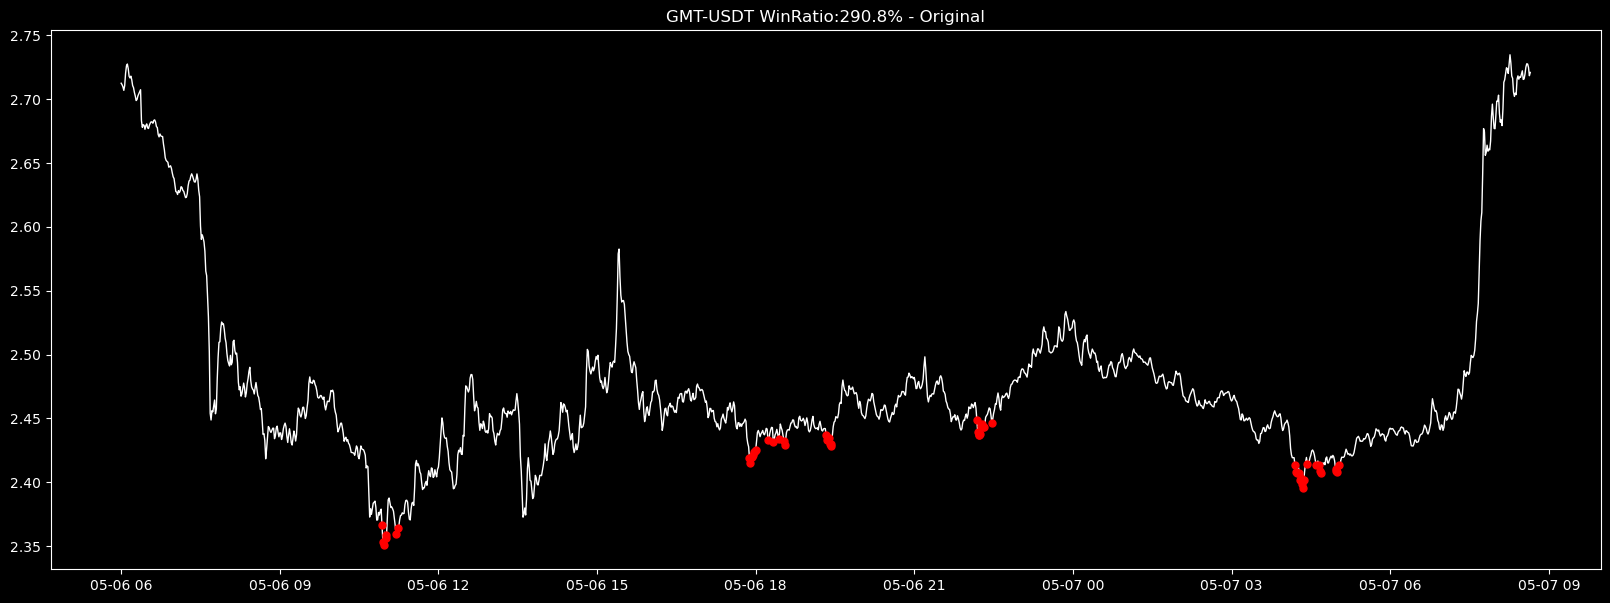

In [12]:
BAD_PERIOD_START="2022-08-30"
BAD_PERIOD_END="2022-11-22"
pair_to_test="GMT/USDT"
# MAX_FORCAST_SIZE=120

BUY_PCT_TEST=1.5
loc_start=0
loc_end=1000000




# loc_start=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_START))
# loc_end=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_END))

pair=pair_to_test
OnePair_DF=maxi_expand(pair=pair,i=loc_start,j=loc_end,window=2,metadata=MetaData,BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,buy_function=buy_function,
                           w1m=2,w5m=2,w15m=2,w1h=2,w1d=2,
                           btc_w1m=2,btc_w5m=2,btc_w15m=2,btc_w1h=2,btc_w1d=2)



OnePair_DT=OnePair_DF.to_numpy()
gc.collect()
OnePair_DT=fixdt(OnePair_DT)
print(OnePair_DT[0,0] == OnePair_DF.iloc[0,0])
print(OnePair_DT[5,5] == OnePair_DF.iloc[5,5])
avggg=hp(OnePair_DF.buy.mean(),"Buy mean pct")

i_win=1440*2

i_start=i_win*20

plot_data("Original", pair_to_test, avggg, OnePair_DF, i_start, i_win, OnePair_DF.buy,dot_color="r",fig_width=25, fig_height=7)
plot_data("Original", pair_to_test, avggg, OnePair_DF, i_start, i_win, OnePair_DF.buy,dot_color="r",fig_width=25, fig_height=7)
plot_data("Original", pair_to_test, avggg, OnePair_DF, i_start, i_win, OnePair_DF.buy,dot_color="r",fig_width=25, fig_height=7)


In [13]:
# xdf=pd.DataFrame()
# count=0
# row_numbers=10000
# for pair in pair_list[:]:
#     if pair != "BTC/USDT" and pair != "EUR/USDT" and pair != "ETH/USDT" :
#         print("working on: "+pair ,end=" -->")
#         try:
            
#             df=maxi_expand(pair=pair,i=0,j=len(df_list1m[pair]),window=WINDOW_SIZE,metadata=MetaData,BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,buy_function=buy_function,
#                            w1m=6,w5m=10,w15m=50,w1h=8,w1d=7,
#                            btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15)
#             print("df original shape "+str(df.shape))
#             print(f"df original shape buy mean : {df.buy.mean()*100}")
#             df=df.reset_index()
#             try:df.pop("num_index")
#             except: pass
#             try:df.pop("index")
#             except: pass
#             try:df.pop("date")
#             except: pass
#             df=data_shufler(df)            
#             #df=data_chooser(df,weight=50,row_numbers=df.buy.sum()*2)
#             df=data_chooser50(df,row_numbers=row_numbers)
#             gc.collect()
#             df=data_cleanup(df)
#             df=df.dropna()
#             print(pair+f" is processed -- {count}/{len(pair_list)}")
#             # print(df.iloc[0:1])
#         except Exception as e:
#             print(f"error while processing {pair} {count}/{len(pair_list)}")
#             print(e)
#         xdf=pd.concat([xdf,df],axis=0)
#         count+=1
#         del(df)
#         gc.collect()
# df=xdf
# del xdf
# gc.collect()


In [14]:
import multiprocessing as mp

def process_pair(pair):
    if pair != "BTC/USDT" and pair != "EUR/USDT" and pair != "ETH/USDT" :
        print("working on: "+pair ,end=" -->")
        try:
            
            df=maxi_expand(pair=pair,i=0,j=len(df_list1m[pair]),window=WINDOW_SIZE,metadata=MetaData,BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,buy_function=buy_function,
                           w1m=6,w5m=10,w15m=50,w1h=8,w1d=7,
                           btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15)
            print("df original shape "+str(df.shape))
            print(f"df original shape buy mean : {df.buy.mean()*100}")
            df=df.reset_index()
            try:df.pop("num_index")
            except: pass
            try:df.pop("index")
            except: pass
            try:df.pop("date")
            except: pass
            df=data_shufler(df)            
            #df=data_chooser(df,weight=50,row_numbers=df.buy.sum()*2)
            df=data_chooser50(df,row_numbers=row_numbers)
            gc.collect()
            df=data_cleanup(df)
            df=df.dropna()
            print(pair+f" is processed -- {count}/{len(pair_list)}")
            # print(df.iloc[0:1])
        except Exception as e:
            print(f"error while processing {pair} {count}/{len(pair_list)}")
            print(e)
            df = None
        return df

if __name__ == '__main__':
    xdf=pd.DataFrame()
    count=0
    row_numbers=10000
    with mp.Pool(processes=4) as pool: #mp.cpu_count()
        results = pool.map(process_pair, pair_list)
        for df in results:
            if df is not None:
                xdf=pd.concat([xdf,df],axis=0)
                count+=1
                del(df)
                gc.collect()
    df=xdf
    del xdf
    gc.collect()
    

working on: ENS/USDTworking on: APE/USDTworking on: SNM/BUSDworking on: TRX/USDT --> --> --> -->maxi custum expend : ENS/USDT with those parameters: w1m=6,w5m=10,w15m=50,w1h=8,w1d=7 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15maxi custum expend : APE/USDT with those parameters: w1m=6,w5m=10,w15m=50,w1h=8,w1d=7 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15maxi custum expend : SNM/BUSD with those parameters: w1m=6,w5m=10,w15m=50,w1h=8,w1d=7 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15
maxi custum expend : TRX/USDT with those parameters: w1m=6,w5m=10,w15m=50,w1h=8,w1d=7 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15


Precent Mean: 5.855%
######################  max expend SNM/BUSD - shape (156489, 499)  buy mean : 5.855 ############################
df original shape (156489, 499)
df original shape buy mean : 5.854724613231601
SNM/BUSD is processed -- 0/112
working on: LUNA/USDT -->maxi custum expend : LUNA/USDT with those parameters: w1m=6,w5m=10,w15m=50,w1h=

In [15]:
df=df.reset_index().drop(columns="num_index")
gc.collect()
for i in range(1):
    df = df.reindex(np.random.permutation(df.index)).reset_index().drop(columns="index")
    gc.collect()
df

,price,high-1,low-1,close-1,volume-1,high-2,low-2,close-2,volume-2,high-3,...,BTC_volume-3_5min,BTC_high-4_5min,BTC_low-4_5min,BTC_close-4_5min,BTC_volume-4_5min,day,hour,minute,lunch_day,buy
0,0.572000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.000000,...,739.418910,-0.006969,-0.005141,-0.005663,605.360330,1,5,41,-758,1
1,3.820000,0.000000,0.000000,0.000000,3.56,0.000000,0.000000,0.000000,12.350,0.000000,...,542.518750,-0.006736,-0.003985,-0.005581,579.284000,4,0,1,-355,1
2,33.915675,-0.002221,0.004676,0.001300,3567.87,-0.005960,0.005501,-0.001342,15473.960,0.004325,...,221.160582,-0.005449,-0.002277,-0.005378,200.687935,1,12,45,-223,0
3,14.815000,0.000337,0.000337,0.000337,0.00,-0.001012,0.000337,0.000337,85.610,-0.001012,...,127.609940,-0.000746,0.000915,0.000379,94.250820,3,20,18,-679,1
4,0.072900,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.000000,...,128.378030,0.000604,0.001454,0.000783,96.998120,2,3,53,-314,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089995,0.110050,0.001363,0.001363,0.001363,0.00,0.001363,0.003180,0.001363,5950.000,0.000454,...,205.213660,-0.001845,0.001947,0.001696,123.195440,5,12,59,-335,1
1089996,0.163467,-0.000260,0.002554,0.002371,241500.10,-0.001789,0.000474,-0.000015,127066.200,-0.002401,...,86.199610,-0.002866,-0.000300,-0.000647,118.047930,7,1,1,-323,0
1089997,5.860500,-0.008276,-0.005546,-0.005546,7094.09,-0.009470,-0.005546,-0.007593,8057.994,-0.008446,...,118.296080,-0.002173,0.001198,-0.000688,129.590440,6,20,0,-855,0
1089998,3.393800,-0.000413,0.001296,0.000000,109.33,0.000177,0.000177,0.000177,5.680,-0.000324,...,593.171030,-0.001501,0.001733,0.001660,773.236620,4,16,23,-685,0


In [16]:
# df=pd.read_feather("../BigFiles/fea/w240_buy4.5_forcasr240min_IS_GOOD.fea")

In [17]:
df

,price,high-1,low-1,close-1,volume-1,high-2,low-2,close-2,volume-2,high-3,...,BTC_volume-3_5min,BTC_high-4_5min,BTC_low-4_5min,BTC_close-4_5min,BTC_volume-4_5min,day,hour,minute,lunch_day,buy
0,0.572000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.000000,...,739.418910,-0.006969,-0.005141,-0.005663,605.360330,1,5,41,-758,1
1,3.820000,0.000000,0.000000,0.000000,3.56,0.000000,0.000000,0.000000,12.350,0.000000,...,542.518750,-0.006736,-0.003985,-0.005581,579.284000,4,0,1,-355,1
2,33.915675,-0.002221,0.004676,0.001300,3567.87,-0.005960,0.005501,-0.001342,15473.960,0.004325,...,221.160582,-0.005449,-0.002277,-0.005378,200.687935,1,12,45,-223,0
3,14.815000,0.000337,0.000337,0.000337,0.00,-0.001012,0.000337,0.000337,85.610,-0.001012,...,127.609940,-0.000746,0.000915,0.000379,94.250820,3,20,18,-679,1
4,0.072900,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.000000,...,128.378030,0.000604,0.001454,0.000783,96.998120,2,3,53,-314,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089995,0.110050,0.001363,0.001363,0.001363,0.00,0.001363,0.003180,0.001363,5950.000,0.000454,...,205.213660,-0.001845,0.001947,0.001696,123.195440,5,12,59,-335,1
1089996,0.163467,-0.000260,0.002554,0.002371,241500.10,-0.001789,0.000474,-0.000015,127066.200,-0.002401,...,86.199610,-0.002866,-0.000300,-0.000647,118.047930,7,1,1,-323,0
1089997,5.860500,-0.008276,-0.005546,-0.005546,7094.09,-0.009470,-0.005546,-0.007593,8057.994,-0.008446,...,118.296080,-0.002173,0.001198,-0.000688,129.590440,6,20,0,-855,0
1089998,3.393800,-0.000413,0.001296,0.000000,109.33,0.000177,0.000177,0.000177,5.680,-0.000324,...,593.171030,-0.001501,0.001733,0.001660,773.236620,4,16,23,-685,0


In [18]:
df.to_feather(f"../BigFiles/fea/w{WINDOW_SIZE}_buy{BUY_PCT}_forcasr{MAX_FORCAST_SIZE}min_{BUY_MODE}.fea")


In [19]:
gc.collect()
print("df choosen data shape"+str(df.shape))
print(f"pair: {(df.shape[0]/2)==df.buy.sum()}")
dt=df.to_numpy(dtype=np.float32)
#dt=df.to_numpy()
dt=np.nan_to_num(dt,nan=0)
#dt=dt.astype(np.float32)
dt=np.nan_to_num(dt, neginf=0) 
dt=np.nan_to_num(dt, posinf=0) 

index_20pct= int(0.2*len(dt[:,0]))
print(index_20pct)


df choosen data shape(1090000, 499)
pair: True
218000


In [20]:
del df
gc.collect()

16

In [21]:
# # feather loading
# df=pd.read_feather(f"../Data/fea/w{WINDOW_SIZE}_buy{BUY_PCT}_forcasr{MAX_FORCAST_SIZE}min_{BUY_MODE}.fea")
# dt=df.to_numpy(dtype=np.float32)
# dt=fixdt(dt)
# index_20pct= int(0.2*len(dt[:,0]))
# gc.collect()



## Self-Normalized Model

## 2- Model Plus - Very deep

In [22]:
# import gc
# from keras.layers import Dense
# from keras.models import Sequential
# from keras.optimizers import Nadam
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# # Define the class weights
# class_weights = {0: 1., 1: 1.}

# gc.collect()

# SizeTunner = 1
# IN_DIM = dt.shape[1] - 1

# model = Sequential()
# model.add(BatchNormalization(input_shape=(IN_DIM,)))
# model.add(Dense(int(300 * SizeTunner), activation='elu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(int(200 * SizeTunner), activation='elu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(int(80 * SizeTunner), activation='elu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(int(80 * SizeTunner), activation='elu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(int(80 * SizeTunner), activation='elu'))
# model.add(BatchNormalization())
# model.add(Dense(int(80 * SizeTunner), activation='elu'))
# model.add(BatchNormalization())
# model.add(Dense(int(80 * SizeTunner), activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(int(20 * SizeTunner), activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(1, activation='sigmoid'))

# print(model.summary())

# optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# callbacks = [
#     ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
#     EarlyStopping(monitor='val_accuracy', mode='auto', patience=6, verbose=1)
# ]

# print("saving file in: " + Model_FileName)
# history = model.fit(dt[index_20pct:, :-1],
#                     dt[index_20pct:, -1],
#                     validation_data=(dt[:index_20pct, :-1], dt[:index_20pct, -1]),
#                     epochs=500,
#                     batch_size=256*10,
#                     callbacks=callbacks,
#                     class_weight=class_weights)

# verydeep_model_file=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5"
# model.save(verydeep_model_file)
# print(verydeep_model_file)
# very_deep_model=load_model(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5")



In [23]:
import gc
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

class_weights = {0: 1., 1: 1.}

gc.collect()

SizeTunner = 1
IN_DIM = dt.shape[1] - 1

model = Sequential()
model.add(BatchNormalization(input_shape=(IN_DIM,)))
model.add(Dense(int(300 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(200 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dense(int(80 * SizeTunner), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(int(20 * SizeTunner), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
    EarlyStopping(monitor='val_accuracy', mode='auto', patience=6, verbose=1)
]

print("saving file in: " + Model_FileName)
history = model.fit(dt[index_20pct:, :-1],
                    dt[index_20pct:, -1],
                    validation_data=(dt[:index_20pct, :-1], dt[:index_20pct, -1]),
                    epochs=500,
                    batch_size=256,  # Reduced batch size
                    callbacks=callbacks,
                    class_weight=class_weights,
                    workers=8)  # Use 8 workers for multi-core systems

verydeep_model_file = f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5"
model.save(verydeep_model_file)
print(verydeep_model_file)
very_deep_model = load_model(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5")


2023-05-01 03:59:07.913996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-01 03:59:07.915321: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-01 03:59:07.915897: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: abj-K93SV
2023-05-01 03:59:07.915917: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: abj-K93SV
2023-05-01 03:59:07.916988: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-05-01 03:59:07.918814: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 390.154.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 498)              1992      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               149700    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 batch_normalization_2 (Batc  (None, 200)              8

2023-05-01 03:59:14.940819: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1737024000 exceeds 10% of free system memory.


Epoch 1/500
3407/3407 [==============================] - 97s 27ms/step - loss: 0.4451 - accuracy: 0.7818 - val_loss: 0.4057 - val_accuracy: 0.8057
Epoch 2/500
3407/3407 [==============================] - 95s 28ms/step - loss: 0.4073 - accuracy: 0.8066 - val_loss: 0.3955 - val_accuracy: 0.8118
Epoch 3/500
3407/3407 [==============================] - 95s 28ms/step - loss: 0.3876 - accuracy: 0.8182 - val_loss: 0.3685 - val_accuracy: 0.8253
Epoch 4/500
3407/3407 [==============================] - 95s 28ms/step - loss: 0.3722 - accuracy: 0.8268 - val_loss: 0.3626 - val_accuracy: 0.8264
Epoch 5/500
3407/3407 [==============================] - 111s 33ms/step - loss: 0.3612 - accuracy: 0.8334 - val_loss: 0.3614 - val_accuracy: 0.8303
Epoch 6/500
3407/3407 [==============================] - 124s 37ms/step - loss: 0.3524 - accuracy: 0.8380 - val_loss: 0.3415 - val_accuracy: 0.8446
Epoch 7/500
3407/3407 [==============================] - 86s 25ms/step - loss: 0.3454 - accuracy: 0.8418 - val_loss:

In [24]:

verydeep_model_file = f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5"

very_deep_model = load_model(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5")


## 3-  Test

### stats plus

In [25]:
USED_MODEL=very_deep_model
USED_MODEL=load_model("/UltimeTradingBot/Data/IS_GOOD/tp450_w240_max240min_Model_minicnn.h5")
#model_init=model
#USED_MODEL=model_init#load_model("/UltimeTradingBot/Data/BUY_UP_CLOSE/tp60_w6_max3min_Model_GoodVeryDeep.h5")
Prediction_Note=USED_MODEL.predict( dt[:, 0:-1])
prediction2=Prediction_Note.round()
hp(prediction2[:,0].mean(),"Normal Prediction ratio")

Y=dt[:,-1].copy()
Pred01=prediction2[:,-1]
Original_Traget_Data=Y

Predicted_Data=Pred01

TruePred=((Original_Traget_Data==Predicted_Data)).copy()
ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")

TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")

LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")

MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")

GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")

fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")

winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)
print(f"========= Win Ratio:{winratio*100} ====================")


2023-05-01 04:36:15.398639: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2171280000 exceeds 10% of free system memory.


34063/34063 [==============================] - 147s 4ms/step
Normal Prediction ratio: 41.658%
ModelAccuracy: 74.016%
True Win Predictions Mean of all: 32.837%
XXX Loss Buy Mean of all: 8.821%
Missed good deal off all: 17.163%
Good Zero prediction Mean: 41.179%
good fiability
========= Win Ratio:78.82519564069327 ====================


In [26]:
PRECISION=-0.25
PesemisticPrediction=(Prediction_Note[:,0]+PRECISION).round()
hp(PesemisticPrediction.mean(),"PesemisticPrediction ratio")
Pred02=PesemisticPrediction

print(f"$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ for Precision : {PRECISION} $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$" )
Predicted_Data=Pred02

TruePred=((Original_Traget_Data==Predicted_Data)).copy()
ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")

TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")

LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")

MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")

GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")

fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")

winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)
print(f"========= Win Ratio:{winratio*100} ====================")
# plot_data("Original", pair_to_test, winratio, OnePair_DF, i_start, 600, OnePair_DF.buy,dot_color="r",fig_width=20, fig_height=7)



PesemisticPrediction ratio: 19.497%
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ for Precision : -0.25 $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ModelAccuracy: 64.402%
True Win Predictions Mean of all: 16.949%
XXX Loss Buy Mean of all: 2.548%
Missed good deal off all: 33.051%
Good Zero prediction Mean: 47.452%
good fiability
========= Win Ratio:86.93132276760528 ====================


# True PredONly

In [27]:
# Change retaindt
# PRECISION=-0.46
# init_model=load_model(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5")
# predictions = init_model.predict(dt[:, :-1])
# TrueWinPred = predictions.round()
TrueWinPred = PesemisticPrediction
for rrr in range(1, 10):
    retrain_dt = dt
    class_1_weight = TrueWinPred.mean()

    import gc
    from keras.layers import Dense, BatchNormalization, Dropout
    from keras.models import Sequential
    from keras.optimizers import Adam
    from keras.callbacks import ModelCheckpoint, EarlyStopping

    index_20pct = int(retrain_dt.shape[1] * 0.2)
    class_weights = {0: 1 - class_1_weight, 1: class_1_weight}
    gc.collect()

    SizeTunner = 1.5
    IN_DIM = retrain_dt.shape[1] - 1

    model = Sequential()
    model.add(BatchNormalization(input_shape=(IN_DIM,)))
    model.add(Dense(int(200 * SizeTunner), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(int(80 * SizeTunner), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(int(80 * SizeTunner), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(int(80 * SizeTunner), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(int(80 * SizeTunner), activation='elu'))
    model.add(Dense(int(80 * SizeTunner), activation='relu'))
    model.add(Dense(int(20 * SizeTunner), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    print(model.summary())

    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    callbacks = [
        ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
        EarlyStopping(monitor='val_accuracy', mode='auto', patience=16, verbose=1)
    ]

    print("saving file in: " + Model_FileName)
    history = model.fit(retrain_dt[index_20pct:, :-1],
                        TrueWinPred[index_20pct:],
                        validation_data=(retrain_dt[:index_20pct, :-1], TrueWinPred[:index_20pct]),
                        epochs=500,
                        batch_size=256 * 5,  # Reduced batch size
                        callbacks=callbacks,
                        class_weight=class_weights,
                        workers=8) 

    true_win_model=model
    wheretosave=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re{rrr}.h5"
    true_win_model.save(wheretosave)
    print(wheretosave)
    USED_MODEL=true_win_model
    bad_Prediction_Note=USED_MODEL.predict( dt[:, 0:-1])
    Pred02=bad_Prediction_Note.round()
    Original_Traget_Data=Y
    Predicted_Data=Pred02[:,0]

    BadTruePred=(Original_Traget_Data==Predicted_Data).copy()
    BadModelAccuracy=hp(BadTruePred.mean(),"ModelAccuracy")

    BadTrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
    BadTrueWinPred_Mean=hp(BadTrueWinPred.mean(),"True Win Predictions Mean of all")

    BadLossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
    BadLossPred_Mean=hp(BadLossPred.mean(),"XXX Loss Buy Mean of all")

    BadMissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
    BadMissedDeal_Mean=hp(BadMissedDealPred.mean(),"Missed good deal off all")

    BadGoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
    BadGoodZero_Mean=hp(BadGoodZeroPred.mean(),"Good Zero prediction Mean")

    fiability=BadTrueWinPred_Mean + BadLossPred_Mean + BadMissedDeal_Mean + BadGoodZero_Mean
    if( fiability == 100):print("good fiability")
    else: print(f"check the fiability {fiability}")
    winratio=BadTrueWinPred_Mean/(BadLossPred_Mean+BadTrueWinPred_Mean)
    print(f"========= Win Ratio:{winratio*100} ====================")
    TrueWinPred=BadTrueWinPred

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Batc  (None, 498)              1992      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 300)               149700    
                                                                 
 batch_normalization_10 (Bat  (None, 300)              1200      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_10 (Dense)            (None, 120)               36120     
                                                                 
 batch_normalization_11 (Bat  (None, 120)             

2023-05-01 04:39:17.335537: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2171082792 exceeds 10% of free system memory.


852/852 [==============================] - 82s 94ms/step - loss: 0.0967 - accuracy: 0.8493 - val_loss: 0.2988 - val_accuracy: 0.8687
Epoch 2/500
852/852 [==============================] - 81s 95ms/step - loss: 0.0728 - accuracy: 0.8904 - val_loss: 0.2592 - val_accuracy: 0.8990
Epoch 3/500
852/852 [==============================] - 79s 93ms/step - loss: 0.0647 - accuracy: 0.9029 - val_loss: 0.2309 - val_accuracy: 0.9293
Epoch 4/500
852/852 [==============================] - 80s 94ms/step - loss: 0.0599 - accuracy: 0.9097 - val_loss: 0.2191 - val_accuracy: 0.9394
Epoch 5/500
852/852 [==============================] - 80s 94ms/step - loss: 0.0567 - accuracy: 0.9147 - val_loss: 0.2486 - val_accuracy: 0.9192
Epoch 6/500
852/852 [==============================] - 80s 94ms/step - loss: 0.0544 - accuracy: 0.9186 - val_loss: 0.1978 - val_accuracy: 0.9192
Epoch 7/500
852/852 [==============================] - 80s 94ms/step - loss: 0.0524 - accuracy: 0.9213 - val_loss: 0.2418 - val_accuracy: 0.92

2023-05-01 05:12:48.527439: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2171280000 exceeds 10% of free system memory.


34063/34063 [==============================] - 127s 4ms/step
ModelAccuracy: 60.636%
True Win Predictions Mean of all: 12.017%
XXX Loss Buy Mean of all: 1.380%
Missed good deal off all: 37.983%
Good Zero prediction Mean: 48.620%
good fiability
========= Win Ratio:89.69918638501157 ====================
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_14 (Bat  (None, 498)              1992      
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 300)               149700    
                                                                 
 batch_normalization_15 (Bat  (None, 300)              1200      
 chNormalization)                                                
                                                                 
 dropout_7 (Drop

2023-05-01 05:15:17.362894: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2171082792 exceeds 10% of free system memory.


852/852 [==============================] - 76s 88ms/step - loss: 0.0474 - accuracy: 0.8956 - val_loss: 0.2321 - val_accuracy: 0.8990
Epoch 2/500
852/852 [==============================] - 75s 88ms/step - loss: 0.0347 - accuracy: 0.9195 - val_loss: 0.1447 - val_accuracy: 0.9394
Epoch 3/500
852/852 [==============================] - 80s 93ms/step - loss: 0.0306 - accuracy: 0.9301 - val_loss: 0.1134 - val_accuracy: 0.9192
Epoch 4/500
852/852 [==============================] - 80s 94ms/step - loss: 0.0282 - accuracy: 0.9361 - val_loss: 0.0982 - val_accuracy: 0.9495
Epoch 5/500
852/852 [==============================] - 81s 94ms/step - loss: 0.0266 - accuracy: 0.9399 - val_loss: 0.1291 - val_accuracy: 0.9293
Epoch 6/500
852/852 [==============================] - 79s 93ms/step - loss: 0.0253 - accuracy: 0.9430 - val_loss: 0.0868 - val_accuracy: 0.9495
Epoch 7/500
852/852 [==============================] - 79s 93ms/step - loss: 0.0245 - accuracy: 0.9448 - val_loss: 0.1286 - val_accuracy: 0.90

## Iteratif model v2

## CNN

In [28]:
# import gc
# from keras.layers import Conv1D, Flatten, Dense, BatchNormalization, Dropout, LeakyReLU,MaxPooling1D,GlobalMaxPooling1D
# from keras.models import Sequential
# from keras.optimizers import SGD
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import Reshape

# # Define the class weights
# class_weights = {0: 1., 1: 1.}

# gc.collect()

# SizeTunner = 0.2
# IN_DIM = dt.shape[1] - 1


# model = Sequential()
# model.add(Reshape((1, IN_DIM), input_shape=(IN_DIM,)))

# model.add(BatchNormalization())

# model.add(Conv1D(256, kernel_size=3, padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv1D(128, kernel_size=3, padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv1D(64, kernel_size=3, padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv1D(32, kernel_size=3, padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GlobalMaxPooling1D())

# model.add(Dense(128))
# model.add(LeakyReLU(alpha=0.2))
# model.add(BatchNormalization())
# model.add(Dense(64))
# model.add(LeakyReLU(alpha=0.2))
# model.add(BatchNormalization())
# model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(1, activation='sigmoid'))

# print(model.summary())

# optimizer = SGD(lr=0.0001, momentum=0.9)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# callbacks = [
#     ModelCheckpoint(filepath=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5',
#                     monitor='val_accuracy', save_best_only=True, save_weights=True),
#     EarlyStopping(monitor='val_accuracy', mode='auto', patience=15, verbose=1)
# ]

# print(f"saving file in: {DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5")

# # Reshape the input data to have a single channel
# X_train = dt[index_20pct:, :-1]
# y_train = dt[index_20pct:, -1]
# X_val = dt[:index_20pct, :-1]
# y_val = dt[:index_20pct, -1]

# history = model.fit(X_train, y_train,
#                     validation_data=(X_val, y_val),
#                     epochs=30,
#                     batch_size=256*5,
#                     callbacks=callbacks,
#                     class_weight=class_weights)

# minicnn_model_file = f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5'
# model.save(minicnn_model_file)
# print(minicnn_model_file)
# minicnn_model = load_model(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5')


In [29]:
import gc
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Flatten, Dense, BatchNormalization, Dropout, Activation, MaxPooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Reshape


In [30]:

# Define the class weights
class_weights = {0: 1., 1: 1.}

gc.collect()

SizeTunner = 0.2
IN_DIM = dt.shape[1] - 1

inputs = Input(shape=(IN_DIM,))

x = Reshape((1, IN_DIM))(inputs)

x = BatchNormalization()(x)

x = Conv1D(256, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv1D(128, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv1D(64, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv1D(32, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = GlobalMaxPooling1D()(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

print(model.summary())

optimizer = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(filepath=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5',
                    monitor='val_accuracy', save_best_only=True, save_weights_only=True),
    EarlyStopping(monitor='val_accuracy', mode='auto', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15, min_lr=0.0001)
]

print(f"saving file in: {DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5")

# Reshape the input data to have a single channel
X_train = dt[index_20pct:, :-1]
y_train = dt[index_20pct:, -1]
X_val = dt[:index_20pct, :-1]
y_val = dt[:index_20pct, -1]

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=300,
                    batch_size=256*5,
                    callbacks=callbacks,
                    class_weight=class_weights)

minicnn_model_file = f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5'
model.save(minicnn_model_file)
print(minicnn_model_file)
minicnn_model = load_model(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5')



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 498)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 498)            0         
                                                                 
 batch_normalization_54 (Bat  (None, 1, 498)           1992      
 chNormalization)                                                
                                                                 
 conv1d (Conv1D)             (None, 1, 256)            382720    
                                                                 
 activation (Activation)     (None, 1, 256)            0         
                                                                 
 batch_normalization_55 (Bat  (None, 1, 256)           1024      
 chNormalization)                                            

In [31]:
# Change retaindt
# PRECISION=-0.46
# init_model=load_model(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5")
# predictions = init_model.predict(dt[:, :-1])
# TrueWinPred = predictions.round()


TrueWinPred = PesemisticPrediction
MODEL_FILE_SUFFIX=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_CNN_'
for rrr in range(1, 10):
    retrain_dt = dt
    class_1_weight = TrueWinPred.mean()

    import gc
    from keras.layers import Dense, BatchNormalization, Dropout
    from keras.models import Sequential
    from keras.optimizers import Adam
    from keras.callbacks import ModelCheckpoint, EarlyStopping

    index_20pct = int(retrain_dt.shape[1] * 0.2)
    class_weights = {0: 1 - class_1_weight, 1: class_1_weight}
    gc.collect()

    SizeTunner = 1.5
    IN_DIM = retrain_dt.shape[1] - 1

    inputs = Input(shape=(IN_DIM,))

    x = Reshape((1, IN_DIM))(inputs)

    x = BatchNormalization()(x)

    x = Conv1D(256, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Conv1D(64, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Conv1D(32, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = GlobalMaxPooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)


    print(model.summary())

    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    callbacks = [
        ModelCheckpoint(filepath=f"{MODEL_FILE_SUFFIX}_ReCNN{rrr}.h5", monitor='val_accuracy', save_best_only=True, save_weights=True),
        EarlyStopping(monitor='val_accuracy', mode='auto', patience=16, verbose=1)
    ]

    print("saving file in: " + f"{MODEL_FILE_SUFFIX}_ReCNN{rrr}.h5")
    history = model.fit(retrain_dt[index_20pct:, :-1],
                        TrueWinPred[index_20pct:],
                        validation_data=(retrain_dt[:index_20pct, :-1], TrueWinPred[:index_20pct]),
                        epochs=500,
                        batch_size=256 * 5,  # Reduced batch size
                        callbacks=callbacks,
                        class_weight=class_weights,
                        workers=8) 

    true_win_model=model
    wheretosave=f"{MODEL_FILE_SUFFIX}_ReCNN{rrr}.h5"
    true_win_model.save(wheretosave)
    print(wheretosave)
    USED_MODEL=true_win_model
    bad_Prediction_Note=USED_MODEL.predict( dt[:, 0:-1])
    Pred02=bad_Prediction_Note.round()
    Original_Traget_Data=Y
    Predicted_Data=Pred02[:,0]

    BadTruePred=(Original_Traget_Data==Predicted_Data).copy()
    BadModelAccuracy=hp(BadTruePred.mean(),"ModelAccuracy")

    BadTrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
    BadTrueWinPred_Mean=hp(BadTrueWinPred.mean(),"True Win Predictions Mean of all")

    BadLossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
    BadLossPred_Mean=hp(BadLossPred.mean(),"XXX Loss Buy Mean of all")

    BadMissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
    BadMissedDeal_Mean=hp(BadMissedDealPred.mean(),"Missed good deal off all")

    BadGoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
    BadGoodZero_Mean=hp(BadGoodZeroPred.mean(),"Good Zero prediction Mean")

    fiability=BadTrueWinPred_Mean + BadLossPred_Mean + BadMissedDeal_Mean + BadGoodZero_Mean
    if( fiability == 100):print("good fiability")
    else: print(f"check the fiability {fiability}")
    winratio=BadTrueWinPred_Mean/(BadLossPred_Mean+BadTrueWinPred_Mean)
    print(f"========= Win Ratio:{winratio*100} ====================")
    TrueWinPred=BadTrueWinPred

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 498)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 1, 498)            0         
                                                                 
 batch_normalization_62 (Bat  (None, 1, 498)           1992      
 chNormalization)                                                
                                                                 
 conv1d_4 (Conv1D)           (None, 1, 256)            382720    
                                                                 
 activation_4 (Activation)   (None, 1, 256)            0         
                                                                 
 batch_normalization_63 (Bat  (None, 1, 256)           1024      
 chNormalization)                                          

In [ ]:
#! pip install -U imbalanced-learn

import gc
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from imblearn.over_sampling import SMOTE

# Define constants
RETRAIN_ITERATIONS = 5
INDEX_20PCT = int(dt.shape[1] * 0.2)
SIZE_TUNER = 3
IN_DIM = dt.shape[1] - 1
CLASS_1_WEIGHT = TrueWinPred.mean()
CLASS_WEIGHTS = {0: 1 - CLASS_1_WEIGHT, 1: CLASS_1_WEIGHT}
BATCH_SIZE = 256 * 10
EPOCHS = 500
LEARNING_RATE = 0.002
BETA_1 = 0.9
BETA_2 = 0.999
PATIENCE = 16
TAKE_PROFIT = BUY_PCT
tp100 = TAKE_PROFIT * 100
MODEL_FILE_SUFFIX = f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'

### Init
Y = dt[:, -1]

class_weights = {0: 1., 1: 1.}

init_model = minicnn_model
predictions = init_model.predict(dt[:, :-1])
predicted_data = predictions.round().flatten()
original_target_data = Y
TrueWinPred = ((predicted_data == 1) & (original_target_data == 1))




def create_model():
    SizeTunner = 0.2
    IN_DIM = dt.shape[1] - 1

    inputs = Input(shape=(IN_DIM,))

    x = Reshape((1, IN_DIM))(inputs)

    x = BatchNormalization()(x)

    x = Conv1D(256, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Conv1D(64, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Conv1D(32, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = GlobalMaxPooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

def evaluate_model(model):
    predictions = model.predict(dt[:, :-1])
    predicted_data = predictions.round().flatten()

    accuracy = (original_target_data == predicted_data).mean()
    true_win_predictions = ((predicted_data == 1) & (original_target_data == 1)).mean()
    loss_buy_mean = ((predicted_data == 1) & (original_target_data == 0)).mean()
    missed_good_deal_mean = ((predicted_data == 0) & (original_target_data == 1)).mean()
    good_zero_prediction_mean = ((predicted_data == 0) & (original_target_data == 0)).mean()

    fiability = true_win_predictions + loss_buy_mean + missed_good_deal_mean + good_zero_prediction_mean
    if fiability == 100:
        print("Good fiability")
    else:
        print(f"Check the fiability: {fiability}")

    win_ratio = true_win_predictions / (loss_buy_mean + true_win_predictions)
    print("---------------------------------------------------------------")
    print(MODEL_FILE_SUFFIX+f'ReCNN{rrr}.h5')
    print(f"accuracy : {accuracy100}%")
    print(f"True win prediction: {true_win_predictions100}%")
    print(f"Win ratio: {win_ratio*100}%")
    print("---------------------------------------------------------------")
    return predicted_data


for rrr in range(RETRAIN_ITERATIONS):
    # Balance the dataset using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(dt[INDEX_20PCT:, :-1], TrueWinPred[INDEX_20PCT:])

    model = create_model()
    
    callbacks = [
        ModelCheckpoint(filepath=MODEL_FILE_SUFFIX+f'ReCNN{rrr}.h5', monitor='val_accuracy', save_best_only=True, save_weights=True),
        EarlyStopping(monitor='val_accuracy', mode='auto', patience=PATIENCE, verbose=1)
    ]

    print("Training model...")
    history = model.fit(X_resampled, y_resampled,
                        validation_data=(dt[:INDEX_20PCT, :-1], TrueWinPred[:INDEX_20PCT]),
                        epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)

    best_model = create_model()
    best_model.load_weights(MODEL_FILE_SUFFIX+f'ReCNN{rrr}.h5')
    # Evaluate the model on the hold-out dataset
    predictions = best_model.predict(dt[:, :-1])
    predictions_rounded = predictions.round()
    original_target_data = Y
    predicted_data = predictions_rounded[:, 0]

    # Compute various metrics
    accuracy = (original_target_data == predicted_data).mean()
    true_win_predictions = ((predicted_data == 1) & (original_target_data == 1)).mean()
    loss_buy_mean = ((predicted_data == 1) & (original_target_data == 0)).mean()
    missed_good_deal_mean = ((predicted_data == 0) & (original_target_data == 1)).mean()
    good_zero_prediction_mean = ((predicted_data == 0) & (original_target_data == 0)).mean()

    fiability = true_win_predictions + loss_buy_mean + missed_good_deal_mean + good_zero_prediction_mean
    if fiability == 100:
        print("Good fiability")
    else:
        print(f"Check the fiability: {fiability}")

    win_ratio = true_win_predictions / (loss_buy_mean + true_win_predictions)
    print("---------------------------------------------------------------")
    print(MODEL_FILE_SUFFIX+f'ReCNN{rrr}.h5')
    print(f"accuracy : {accuracy*100}%")
    print(f"True win prediction: {true_win_predictions*100}%")
    print(f"Win ratio: {win_ratio*100}%")
    print("---------------------------------------------------------------")
    # Use the true win predictions for retraining
    TrueWinPred = ((predicted_data == 1) & (original_target_data == 1)).copy()







In [ ]:
import imblearn

In [ ]:
# import gc
# from keras.layers import Conv1D, Flatten, Dense, BatchNormalization, Dropout
# from keras.models import Sequential
# from keras.optimizers import SGD
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import Reshape

# # Define the class weights
# class_weights = {0: 1., 1: 1.}

# gc.collect()

# SizeTunner = 0.2
# IN_DIM = dt.shape[1] - 1

# model = Sequential()
# model.add(Reshape((1, IN_DIM), input_shape=(IN_DIM,)))

# model.add(BatchNormalization())

# model.add(Conv1D(128, kernel_size=3, activation='elu', padding='same'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv1D(64, kernel_size=3, activation='elu', padding='same'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Flatten())
# model.add(Dense(64, activation='elu'))
# model.add(BatchNormalization())
# model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(1, activation='sigmoid'))

# print(model.summary())

# optimizer = SGD(lr=0.0001, momentum=0.9)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# callbacks = [
#     ModelCheckpoint(filepath=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5',
#                     monitor='val_accuracy', save_best_only=True, save_weights=True),
#     EarlyStopping(monitor='val_accuracy', mode='auto', patience=15, verbose=1)
# ]

# print(f"saving file in: {DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5")

# # Reshape the input data to have a single channel
# X_train = dt[index_20pct:, :-1]
# y_train = dt[index_20pct:, -1]
# X_val = dt[:index_20pct, :-1]
# y_val = dt[:index_20pct, -1]



# history = model.fit(X_train, y_train,
#                     validation_data=(X_val, y_val),
#                     epochs=30,
#                     batch_size=256*5,
#                     callbacks=callbacks,
#                     class_weight=class_weights)

# minicnn_model_file = f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5'
# model.save(minicnn_model_file)
# print(minicnn_model_file)
# minicnn_model = load_model(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5')


## Big Model

In [ ]:
import gc
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Define the class weights
class_weights = {0: 3., 1: 1.}

gc.collect()

SizeTunner = 3
IN_DIM = dt.shape[1] - 1

model = Sequential()
model.add(BatchNormalization(input_shape=(IN_DIM,)))
model.add(Dense(int(300 * SizeTunner), activation='softplus'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(200 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(int(200 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(int(80 * SizeTunner), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(int(80 * SizeTunner), activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(int(20 * SizeTunner), activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

#optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
optimizer = Nadam(lr=0.005, beta_1=0.8, beta_2=0.99, clipnorm=1.0) #faster
#optimizer = Nadam(lr=0.0005, beta_1=0.95, beta_2=0.999, epsilon=1e-08) #optimizer more accurate

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
    EarlyStopping(monitor='val_accuracy', mode='auto', patience=20, verbose=1)
]

print("saving file in: " + Model_FileName)
history = model.fit(dt[index_20pct:, :-1],
                    dt[index_20pct:, -1],
                    validation_data=(dt[:index_20pct, :-1], dt[:index_20pct, -1]),
                    epochs=500,
                    batch_size=256*10,
                    callbacks=callbacks,
                    class_weight=class_weights)

verydeep_model_file=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryBig.h5"
model.save(verydeep_model_file)
print(verydeep_model_file)
very_deep_model=load_model(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryBig.h5")
#868/868 [==============================] - 30s 35ms/step - loss: 0.6078 - accuracy: 0.6664 - val_loss: 0.6107 - val_accuracy: 0.6639 >0.6646
#Results after 380 min
# Epoch 133/500
# 347/347 [==============================] - 138s 398ms/step - loss: 0.5867 - accuracy: 0.6842 - val_loss: 0.5839 - val_accuracy: 0.6863
# Epoch 134/500
# 347/347 [==============================] - 137s 395ms/step - loss: 0.5865 - accuracy: 0.6843 - val_loss: 0.5845 - val_accuracy: 0.6861
# Epoch 134: early stopping



In [ ]:
import gc
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define constants
RETRAIN_ITERATIONS = 5
INDEX_20PCT = int(dt.shape[1] * 0.2)
SIZE_TUNER = 3
IN_DIM = dt.shape[1] - 1
CLASS_1_WEIGHT = TrueWinPred.mean()
CLASS_WEIGHTS = {0: 1 - CLASS_1_WEIGHT, 1: CLASS_1_WEIGHT}
BATCH_SIZE = 256 * 10
EPOCHS = 500
LEARNING_RATE = 0.002
BETA_1 = 0.9
BETA_2 = 0.999
PATIENCE = 16
TAKE_PROFIT=BUY_PCT
tp100=TAKE_PROFIT*100
MODEL_FILE_SUFFIX=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_Big'

### Init
Y=dt[:, -1]

init_model=very_deep_model
predictions = init_model.predict(dt[:, :-1])
predictions_rounded = predictions.round()
original_target_data = Y
predicted_data = predictions_rounded[:, 0]
TrueWinPred=((predicted_data == 1) & (original_target_data == 1))

for rrr in range(RETRAIN_ITERATIONS):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(IN_DIM,)))
    model.add(Dense(int(200 * SIZE_TUNER), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(int(80 * SIZE_TUNER), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(int(80 * SIZE_TUNER), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(int(80 * SIZE_TUNER), activation='elu'))
    model.add(Dense(int(80 * SIZE_TUNER), activation='relu'))
    model.add(Dense(int(20 * SIZE_TUNER), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Nadam(lr=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    callbacks = [
        ModelCheckpoint(filepath=MODEL_FILE_SUFFIX+f'Model_Re{rrr}.h5', monitor='val_accuracy', save_best_only=True, save_weights=True),
        EarlyStopping(monitor='val_accuracy', mode='auto', patience=PATIENCE, verbose=1)
    ]

    print("Training model...")
    history = model.fit(dt[INDEX_20PCT:, :-1], TrueWinPred[INDEX_20PCT:],
                        validation_data=(dt[:INDEX_20PCT, :-1], TrueWinPred[:INDEX_20PCT]),
                        epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, class_weight=CLASS_WEIGHTS)

    # Load the best model
    best_model = Sequential()
    best_model.add(BatchNormalization(input_shape=(IN_DIM,)))
    best_model.add(Dense(int(200 * SIZE_TUNER), activation='elu'))
    best_model.add(BatchNormalization())
    best_model.add(Dropout(0.2))

    best_model.add(Dense(int(80 * SIZE_TUNER), activation='elu'))
    best_model.add(BatchNormalization())
    best_model.add(Dropout(0.2))

    best_model.add(Dense(int(80 * SIZE_TUNER), activation='elu'))
    best_model.add(BatchNormalization())
    best_model.add(Dense(int(80 * SIZE_TUNER), activation='elu'))
    best_model.add(Dense(int(80 * SIZE_TUNER), activation='relu'))
    best_model.add(Dense(int(20 * SIZE_TUNER), activation='relu'))
    best_model.add(Dense(1, activation='sigmoid'))

    best_model.load_weights(MODEL_FILE_SUFFIX+f'Model_Re{rrr}.h5')

    # Evaluate the model on the hold-out dataset
    predictions = best_model.predict(dt[:, :-1])
    predictions_rounded = predictions.round()
    original_target_data = Y
    predicted_data = predictions_rounded[:, 0]

    # Compute various metrics
    accuracy = (original_target_data == predicted_data).mean()
    true_win_predictions = ((predicted_data == 1) & (original_target_data == 1)).mean()
    loss_buy_mean = ((predicted_data == 1) & (original_target_data == 0)).mean()
    missed_good_deal_mean = ((predicted_data == 0) & (original_target_data == 1)).mean()
    good_zero_prediction_mean = ((predicted_data == 0) & (original_target_data == 0)).mean()

    fiability = true_win_predictions + loss_buy_mean + missed_good_deal_mean + good_zero_prediction_mean
    if fiability == 100:
        print("Good fiability")
    else:
        print(f"Check the fiability: {fiability}")

    win_ratio = true_win_predictions / (loss_buy_mean + true_win_predictions)
    print("---------------------------------------------------------------")
    print(MODEL_FILE_SUFFIX+f'Model_Re{rrr}.h5')
    print(f"accuracy : {accuracy*100}%")
    print(f"True win prediction: {true_win_predictions*100}%")
    print(f"Win ratio: {win_ratio*100}%")
    print("---------------------------------------------------------------")
    # Use the true win predictions for retraining
    TrueWinPred = ((predicted_data == 1) & (original_target_data == 1)).copy()
  


## Win-Loss Double Model

deep neural network to predict a binary outcome (win or loss) and applying class weights to the loss function. To implement cost-sensitive learning or ensemble methods, you can make the following modifications:


In [ ]:
# import gc
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from keras.layers import Dense, Dropout, BatchNormalization
# from keras.models import Sequential
# from keras.optimizers import Nadam
# from keras.callbacks import ModelCheckpoint, EarlyStopping

# # Custom cost-sensitive loss function
# def cost_sensitive_loss(y_true, y_pred):
#     cost_matrix = tf.constant([[0, 1], [10, 0]], dtype=tf.float32)
    
#     y_pred_probs = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
#     y_pred_1_probs = 1 - y_pred_probs
    
#     y_true_int = tf.cast(y_true, tf.int32)
#     cost_weights = tf.gather(cost_matrix, y_true_int[:, 0])
#     loss = -tf.reduce_mean(cost_weights * (y_true * tf.math.log(y_pred_probs) + (1 - y_true) * tf.math.log(y_pred_1_probs)))

#     return loss


# # Function to create the model
# def create_model(input_dim):
#     model = Sequential()
#     model.add(BatchNormalization(input_shape=(input_dim,)))
#     model.add(Dense(200, activation='elu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))

#     model.add(Dense(80, activation='elu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))

#     model.add(Dense(80, activation='elu'))
#     model.add(BatchNormalization())

#     model.add(Dense(1, activation='sigmoid'))
    
#     return model

# # Prepare the data
# retrain_dt = dt
# index_20pct = int(retrain_dt.shape[1] * 0.2)
# X_train, X_val = retrain_dt[index_20pct:, :-1], retrain_dt[:index_20pct, :-1]
# y_train, y_val = retrain_dt[index_20pct:,-1], retrain_dt[:index_20pct,-1]

# # Define the optimizer and callbacks
# optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
# callbacks = [
#     ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
#     EarlyStopping(monitor='val_accuracy', mode='auto', patience=16, verbose=1)
# ]

# # Train the model for class 1 (win)
# model_win = create_model(input_dim=IN_DIM)
# model_win.compile(optimizer=optimizer, loss=cost_sensitive_loss, metrics=['accuracy'])
# model_win.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=256 * 5, callbacks=callbacks)

# # Train the model for class 0 (loss)
# model_loss = create_model(input_dim=IN_DIM)
# model_loss.compile(optimizer=optimizer, loss=cost_sensitive_loss,metrics=['accuracy'])
# model_loss.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=256 * 5, callbacks=callbacks)

# # Combine the predictions from both models
# win_preds = model_win.predict(dt[:, 0:-1])
# loss_preds = model_loss.predict(dt[:, 0:-1])

# # Use a strategy such as averaging, voting, or another combination method
# combined_preds = (win_preds + loss_preds) / 2
# combined_preds_rounded = np.round(combined_preds)

# # Calculate the accuracy and other metrics
# y_true = Y
# accuracy = np.mean(combined_preds_rounded == y_true)
# print(f"Accuracy: {accuracy * 100:.2f}%")

# # Additional metrics
# true_positive = np.mean((combined_preds_rounded == 1) & (y_true == 1))
# false_positive = np.mean((combined_preds_rounded == 1) & (y_true == 0))
# true_negative = np.mean((combined_preds_rounded == 0) & (y_true == 0))
# false_negative = np.mean((combined_preds_rounded == 0) & (y_true == 1))

# print(f"True Positive Rate: {true_positive * 100:.2f}%")
# print(f"False Positive Rate: {false_positive * 100:.2f}%")
# print(f"True Negative Rate: {true_negative * 100:.2f}%")
# print(f"False Negative Rate: {false_negative * 100:.2f}%")


## Combined model

In [ ]:
# from keras.layers import Input, concatenate
# from keras.models import Model

# # 1. Freeze the weights of model_win and model_loss
# for layer in model_win.layers:
#     layer.trainable = False

# for layer in model_loss.layers:
#     layer.trainable = False

# # 2. Add an additional layer to each model to obtain the intermediate features
# model_win_intermediate = Dense(64, activation='relu')(model_win.output)
# model_loss_intermediate = Dense(64, activation='relu')(model_loss.output)

# # 3. Create a new model that takes the outputs of the intermediate layers from both models and combines them
# combined_input = concatenate([model_win_intermediate, model_loss_intermediate])
# combined_output = Dense(1, activation='sigmoid')(combined_input)

# combined_model = Model(inputs=[model_win.input, model_loss.input], outputs=combined_output)

# # 4. Train the new model to make predictions using the intermediate features from both models
# optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
# combined_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# callbacks = [
#     ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
#     EarlyStopping(monitor='val_accuracy', mode='auto', patience=16, verbose=1)
# ]

# # Train the combined model
# combined_model.fit([X_train, X_train], y_train, validation_data=([X_val, X_val], y_val), epochs=500, batch_size=256 * 5, callbacks=callbacks)

# # Make predictions using the combined model
# combined_preds = combined_model.predict([dt[:, 0:-1], dt[:, 0:-1]])
# combined_preds_rounded = np.round(combined_preds)

# # Calculate the accuracy and other metrics
# y_true = Y
# accuracy = np.mean(combined_preds_rounded == y_true)
# print(f"Accuracy: {accuracy * 100:.2f}%")


In [ ]:
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Dropout, BatchNormalization, Input, concatenate
from keras.models import Sequential, Model
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import BinaryCrossentropy

# Custom cost-sensitive loss function
def cost_sensitive_loss(y_true, y_pred):
    cost_matrix = tf.constant([[0, 1], [10, 0]], dtype=tf.float32)
    y_pred_probs = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    y_pred_1_probs = 1 - y_pred_probs
    y_true_int = tf.cast(y_true, tf.int32)
    cost_weights = tf.gather(cost_matrix, y_true_int[:, 0])
    loss = -tf.reduce_mean(cost_weights * (y_true * tf.math.log(y_pred_probs) + (1 - y_true) * tf.math.log(y_pred_1_probs)))

    return loss

# Function to create the model
def create_model(input_dim):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(input_dim,)))
    model.add(Dense(200, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(80, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(80, activation='elu'))
    model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))
    
    return model

def train_model(model, X_train, y_train, X_val, y_val, loss_function):
    optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
    callbacks = [
        ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
        EarlyStopping(monitor='val_accuracy', mode='auto', patience=16, verbose=1)
    ]

    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=256 * 5, callbacks=callbacks)

# Prepare the data
retrain_dt = dt
index_20pct = int(retrain_dt.shape[1] * 0.2)
X_train, X_val = retrain_dt[index_20pct:, :-1], retrain_dt[:index_20pct, :-1]
y_train, y_val = retrain_dt[index_20pct:,-1], retrain_dt[:index_20pct,-1]


# Train the model for class 1 (win)
model_win = create_model(input_dim=IN_DIM)
model_win.compile(optimizer=optimizer, loss=cost_sensitive_loss, metrics=['accuracy'])
model_win.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=256 * 5, callbacks=callbacks)

# Train the model for class 0 (loss)
model_loss = create_model(input_dim=IN_DIM)
model_loss.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=['accuracy'])
model_loss.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=256 * 5, callbacks=callbacks)


# Freeze the weights of model_win and model_loss
for layer in model_win.layers:
    layer.trainable = False

for layer in model_loss.layers:
    layer.trainable = False

# Add an additional layer to each model
# Add an additional layer to each model to obtain the intermediate features
model_win_intermediate = Dense(64, activation='relu')(model_win.output)
model_loss_intermediate = Dense(64, activation='relu')(model_loss.output)

# Create a new model that takes the outputs of the intermediate layers from both models and combines them
combined_input = concatenate([model_win_intermediate, model_loss_intermediate])
combined_output = Dense(1, activation='sigmoid')(combined_input)

combined_model = Model(inputs=[model_win.input, model_loss.input], outputs=combined_output)

# Train the new model to make predictions using the intermediate features from both models
optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
combined_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
    EarlyStopping(monitor='val_accuracy', mode='auto', patience=16, verbose=1)
]

# Train the combined model
combined_model.fit([X_train, X_train], y_train, validation_data=([X_val, X_val], y_val), epochs=500, batch_size=256 * 5, callbacks=callbacks)

# Make predictions using the combined model
combined_preds = combined_model.predict([dt[:, 0:-1], dt[:, 0:-1]])
combined_preds_rounded = np.round(combined_preds).reshape(-1)

# Calculate the accuracy and other metrics
y_true = Y
accuracy = np.mean(combined_preds_rounded == y_true)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Additional metrics
true_positive = np.mean((combined_preds_rounded == 1) & (y_true == 1))
false_positive = np.mean((combined_preds_rounded == 1) & (y_true == 0))
true_negative = np.mean((combined_preds_rounded == 0) & (y_true == 0))
false_negative = np.mean((combined_preds_rounded == 0) & (y_true == 1))

print(f"True Positive Rate: {true_positive * 100:.2f}%")
print(f"False Positive Rate: {false_positive * 100:.2f}%")
print(f"True Negative Rate: {true_negative * 100:.2f}%")
print(f"False Negative Rate: {false_negative * 100:.2f}%")



In [ ]:
from keras.layers import Lambda

# Create a new input layer for the single input
single_input = Input(shape=(IN_DIM,))

# Duplicate the input for the two original models
input_duplication = Lambda(lambda x: tf.tile(tf.expand_dims(x, axis=1), [1, 2, 1]))(single_input)
input_for_model_win = Lambda(lambda x: x[:, 0])(input_duplication)
input_for_model_loss = Lambda(lambda x: x[:, 1])(input_duplication)

# Feed the duplicated input into the original models
model_win_output = model_win(input_for_model_win)
model_loss_output = model_loss(input_for_model_loss)

# Combine the outputs of the original models
combined_input = concatenate([model_win_output, model_loss_output])
combined_output = Dense(1, activation='sigmoid')(combined_input)

# Create the new model
single_input_combined_model = Model(inputs=single_input, outputs=combined_output)


In [ ]:
combined_preds = single_input_combined_model.predict(dt[:, 0:-1])


In [ ]:
# Make predictions using the combined model
# combined_preds = combined_model.predict([dt[:, 0:-1], dt[:, 0:-1]])

combined_preds_rounded = np.round(combined_preds).reshape(-1)

# Calculate the accuracy and other metrics
y_true = Y
accuracy = np.mean(combined_preds_rounded == y_true)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Additional metrics
true_positive = np.mean((combined_preds_rounded == 1) & (y_true == 1))
false_positive = np.mean((combined_preds_rounded == 1) & (y_true == 0))
true_negative = np.mean((combined_preds_rounded == 0) & (y_true == 0))
false_negative = np.mean((combined_preds_rounded == 0) & (y_true == 1))

print(f"True Positive Rate: {true_positive * 100:.2f}%")
print(f"False Positive Rate: {false_positive * 100:.2f}%")
print(f"True Negative Rate: {true_negative * 100:.2f}%")
print(f"False Negative Rate: {false_negative * 100:.2f}%")


In [ ]:
# very_deep_good_model=model
wheretosave=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_CombinedLOssWin.h5"
combined_model.save(wheretosave)
print(wheretosave)

In [ ]:

import os
import glob

def find_matching_files(path="/UltimeTradingBot/Data", pattern=f"**/*w{WINDOW_SIZE}*.h5"):
    pattern = os.path.join(path, pattern)
    matching_files = []
    
    for file_path in glob.iglob(pattern, recursive=True):
        if os.path.isfile(file_path):
            matching_files.append(file_path)
    
    return matching_files


pattern = f"*/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_*"
path="/UltimeTradingBot/Data"
Model_lists = find_matching_files(path, pattern)
print(Model_lists)
import random
random.shuffle(Model_lists)
print(Model_lists)

#####################################################################


# try: 
#     if tests_history:
#         print(tests_history.head)
# except:
#         tests_history = pd.DataFrame(columns=['Model-FileName', 'TAKE_PROFIT', 'STOP_LOSS', 'MAX_HOLDING_TIME', 'FinalValue', 'Profit', 'ROI', 'Nbr_wins', 'best_win', 'worst_loss'])
# tests_history_filename=f"workdir/backtest/test_all_models_sl{STOP_LOSS}_between_{start_period.date()}--{end_period.date()}.csv"
# pdebug(f"saving Test in {tests_history_filename}")





## Test On special coin

In [ ]:
## Generate Data
Mlist=Model_lists
# MAX_FORCAST_SIZE=40
# Mlist=[              f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re2.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re4.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re5.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re6.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re7.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re8.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re9.h5",
#                        f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryBig.h5",
    
#                         ]

Mlist=[              
                       '/UltimeTradingBot/Data/IS_GOOD/tp210_w240_max120min_Model_minicnn.h5'
                                                ]
PRECISION=-0.0
BAD_PERIOD_START="2022-08-30"
BAD_PERIOD_END="2022-11-22"
pair_to_test="SOL/USDT"
MAX_FORCAST_SIZE=120

BUY_PCT_TEST=1.5
loc_start=0
loc_end=1000000


i_start=71000
i_end=i_start+200

# loc_start=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_START))
# loc_end=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_END))

pair=pair_to_test
OnePair_DF=maxi_expand(pair=pair,i=loc_start,j=loc_end,window=WINDOW_SIZE,metadata=MetaData,BUY_PCT=BUY_PCT_TEST,SELL_PCT=SELL_PCT,buy_function=is_high_win,
                           w1m=6,w5m=10,w15m=50,w1h=8,w1d=7,
                           btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15)



OnePair_DT=OnePair_DF.to_numpy()
gc.collect()
OnePair_DT=fixdt(OnePair_DT)
print(OnePair_DT[0,0] == OnePair_DF.iloc[0,0])
print(OnePair_DT[5,5] == OnePair_DF.iloc[5,5])
hp(OnePair_DF.buy.mean(),"Buy mean pct")



plot_data("Original", pair_to_test, winratio, OnePair_DF, i_start, 600, OnePair_DF.buy,dot_color="r",fig_width=20, fig_height=7)

for Model_FileName in Mlist:
    try:
        USED_MODEL=load_model(Model_FileName)


        OnePair_PredNote=USED_MODEL.predict( OnePair_DT[:, 0:-1])
        for PRECISION in [-0.0,-0.1,-0.2,-0.3,-0.4,-0.41,-0.42,-0.43,-0.44,-0.45,-0.46,-0.47,-0.48,-0.49,-0.495,-0.499]:
            print(f'################################################### Precision: {PRECISION} #######################################################')
            OnePair_Pred=(OnePair_PredNote+PRECISION).round()

            gc.collect()

            Original_Traget_Data=OnePair_DT[:,-1]
            Predicted_Data=OnePair_Pred[:,0]
            gc.collect()
            TruePred=(Original_Traget_Data==Predicted_Data).copy()
            ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")
            gc.collect()
            TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
            TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")
            gc.collect()
            LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
            LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")
            gc.collect()

            MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
            MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")
            gc.collect()

            GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
            GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")
            gc.collect()

            fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
            if( fiability == 100):print("good fiability")
            else: print(f"check the fiability {fiability}")
            winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)

            print(f"========= Win Ratio:{winratio*100} %====================")




            PREDICTION_TO_TEST=Predicted_Data



            plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, i_start, 600, PREDICTION_TO_TEST,dot_color="g",fig_width=20, fig_height=7)
    except:
        print(f"error in plotting:{Model_FileName}")

In [ ]:
plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, 75000, 2000, PREDICTION_TO_TEST,dot_color="g",fig_width=20, fig_height=7)


In [ ]:
# ## External and other Models


# # Mlist=[ f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model_minicnn.h5',
    
# #                         ]







# plot_data("Original", pair_to_test, winratio, OnePair_DF, i_start, 600, OnePair_DF.buy,dot_color="r",fig_width=20, fig_height=7)

# for Model_FileName in Mlist:

#     USED_MODEL=load_model(Model_FileName)


#     OnePair_PredNote=USED_MODEL.predict( OnePair_DT[:, 0:-1])
#     OnePair_Pred=OnePair_PredNote.round()

#     gc.collect()

#     Original_Traget_Data=OnePair_DT[:,-1]
#     Predicted_Data=OnePair_Pred[:,0]
#     gc.collect()
#     TruePred=(Original_Traget_Data==Predicted_Data).copy()
#     ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")
#     gc.collect()
#     TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
#     TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")
#     gc.collect()
#     LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
#     LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")
#     gc.collect()

#     MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
#     MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")
#     gc.collect()

#     GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
#     GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")
#     gc.collect()

#     fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
#     if( fiability == 100):print("good fiability")
#     else: print(f"check the fiability {fiability}")
#     winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)

#     print(f"========= Win Ratio:{winratio*100} %====================")




#     PREDICTION_TO_TEST=Predicted_Data



#     plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, i_start, 600, PREDICTION_TO_TEST,dot_color="g",fig_width=20, fig_height=7)

In [ ]:
# plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, i_start+15000, 1000, PREDICTION_TO_TEST,dot_color="g",fig_width=20, fig_height=7)

In [ ]:
# def plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, i_start, window_size, PREDICTION_TO_TEST, dot_color="g", fig_width=20, fig_height=5):
#     i_end = i_start + window_size
#     mname = Model_FileName.replace("/UltimeTradingBot/Data","")
#     coin = pair_to_test.replace('/', '-')
#     mtitle = f"{coin} WinRatio:{hp(winratio)}% - {mname}".replace("/", "-")

#     x = np.linspace(0, 10, 500)
#     dashes = []  # 10 points on, 5 off, 100 on, 5 off
#     fig, ax = plt.subplots(figsize=(fig_width, fig_height))
#     line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
#                  label='price',c="w")
#     line1.set_dashes(dashes)
#     plt.plot(OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].price, 'ro',c=dot_color,markersize=5)
#     plt.title(mtitle)

#     plt.show()

# # plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, i_start, 300, PREDICTION_TO_TEST,dot_color="g")






In [ ]:
# XX=OnePair_DT[:100000,:-1]
# YY=OnePair_DT[:100000,-1]
# precision=0.0
# # Good_Prediction_Note=very_deep_good_model.predict( XX)
# # Bad_Prediction_Note=very_deep_bad_model.predict( XX)
# # Initial_Pred_Note=model_init.predict( XX)
# Predicted_Data=OnePair_Pred[:300000,0]
# goodp=(Good_Prediction_Note-precision).round()
# # badp=(Bad_Prediction_Note).round()
# # initp=Initial_Pred_Note.round()

# # Original_Traget_Data=YY

# #Predicted_Data=((goodp==badp|initp==goodp))[:,0]
# Predicted_Data=(goodp)[:,0]

# GoodTruePred=(Original_Traget_Data==Predicted_Data).copy()
# GoodModelAccuracy=hp(GoodTruePred.mean(),"ModelAccuracy")

# GoodTrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
# GoodTrueWinPred_Mean=hp(GoodTrueWinPred.mean(),"True Win Predictions Mean of all")

# GoodLossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
# GoodLossPred_Mean=hp(GoodLossPred.mean(),"XXX Loss Buy Mean of all")

# GoodMissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
# GoodMissedDeal_Mean=hp(GoodMissedDealPred.mean(),"Missed good deal off all")

# GoodGoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
# GoodGoodZero_Mean=hp(GoodGoodZeroPred.mean(),"Good Zero prediction Mean")

# winratio=GoodTrueWinPred_Mean/(GoodTrueWinPred_Mean+GoodLossPred_Mean)
# fiability=GoodTrueWinPred_Mean + GoodLossPred_Mean + GoodMissedDeal_Mean + GoodGoodZero_Mean
# if( fiability == 100):print("good fiability")
# else: print(f"check the fiability {fiability}")
# print(f"========= Win Ratio:{winratio*100} ====================")


In [ ]:
# def test_prediction(XX,YY,USEDMODEL)
# XX=OnePair_DT[:100000,:-1]
# YY=OnePair_DT[:100000,-1]

# # Good_Prediction_Note=very_deep_good_model.predict( XX)
# # Bad_Prediction_Note=very_deep_bad_model.predict( XX)
# # Initial_Pred_Note=model_init.predict( XX)
# goodp=(Good_Prediction_Note-precision).round()
# # badp=(Bad_Prediction_Note).round()
# # initp=Initial_Pred_Note.round()

# # Original_Traget_Data=YY

# #Predicted_Data=((goodp==badp|initp==goodp))[:,0]
# Predicted_Data=(goodp)[:,0]

# GoodTruePred=(Original_Traget_Data==Predicted_Data).copy()
# GoodModelAccuracy=hp(GoodTruePred.mean(),"ModelAccuracy")

# GoodTrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
# GoodTrueWinPred_Mean=hp(GoodTrueWinPred.mean(),"True Win Predictions Mean of all")

# GoodLossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
# GoodLossPred_Mean=hp(GoodLossPred.mean(),"XXX Loss Buy Mean of all")

# GoodMissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
# GoodMissedDeal_Mean=hp(GoodMissedDealPred.mean(),"Missed good deal off all")

# GoodGoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
# GoodGoodZero_Mean=hp(GoodGoodZeroPred.mean(),"Good Zero prediction Mean")

# winratio=GoodTrueWinPred_Mean/(GoodTrueWinPred_Mean+GoodLossPred_Mean)
# fiability=GoodTrueWinPred_Mean + GoodLossPred_Mean + GoodMissedDeal_Mean + GoodGoodZero_Mean
# if( fiability == 100):print("good fiability")
# else: print(f"check the fiability {fiability}")
# print(f"========= Win Ratio:{winratio*100} ====================")
